In [1]:
# Time Series Clustering: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/tslearn/bases/bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.config_loader import ConfigLoader
from src.core.clients.bigquery import BigQueryClient
%matplotlib inline

bq_client = BigQueryClient()
config_loader = ConfigLoader()

from src.core.models.xgboost import XgboostModel

model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260129_205923/model_0.pickle'
)
type(model)

df = model.training_df.copy()
df["actuals"] = df[config_loader.target_col]
df['predictions'] = model.predict(df[model.features], False)
df['error'] = abs(df['predictions'] - df["actuals"])/df["actuals"]

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260129_205923/model_0.pickle


## 1. Load and Prepare Time Series Data
Load your time series data. Adjust the path and column names as needed.

In [29]:
# Example: Load time series data (replace with your actual data source)
# df = pd.read_csv('path/to/your/timeseries.csv')
# Example structure: columns=['series_id', 'date', 'value']

# Use synthetic data for clustering demo
ts_data = model.training_df[[  
    "fea_item_monthly_sales_lag_1_months",
    "fea_item_monthly_sales_lag_2_months",
    "fea_item_monthly_sales_lag_3_months",
    "fea_item_monthly_sales_lag_4_months",
    "fea_item_monthly_sales_lag_5_months",
    "fea_item_monthly_sales_lag_6_months",
    "fea_item_monthly_sales_lag_7_months",
    "fea_item_monthly_sales_lag_8_months",
    "fea_item_monthly_sales_lag_9_months",
    "fea_item_monthly_sales_lag_10_months",
    "fea_item_monthly_sales_lag_11_months",
    "fea_item_monthly_sales_lag_12_months"]].sample(int(model.training_df.shape[0]*.30))

In [31]:
ts_data.shape

(17923, 12)

## 2. Preprocess and Standardize Data
Standardize the time series for clustering.

In [32]:
# Standardize each time series
scaler = StandardScaler()
ts_data_scaled = scaler.fit_transform(ts_data)

# Convert to tslearn format
ts_dataset = to_time_series_dataset(ts_data_scaled)
print(f"Shape for clustering: {ts_dataset.shape}")

Shape for clustering: (17923, 12, 1)


## 3. Cluster Time Series
Use KMeans (DTW or Euclidean) to cluster the time series.

In [33]:
# Choose number of clusters
n_clusters = 20

# KMeans clustering with DTW distance (can use 'euclidean' for faster, less robust clustering)
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42, n_jobs=-1)
labels = km.fit_predict(ts_dataset)

print(f"Cluster labels: {labels}")

Cluster labels: [ 0  0  0 ...  6  6 13]


In [57]:
ts_data["clusters"] = labels
results = ts_data.merge(df, left_index=True, right_index=True)[["clusters", "error", "fea_item_monthly_sales_roll_coeffvar_12_months"]]
df_results_display = results.groupby(["clusters"])[["error", "fea_item_monthly_sales_roll_coeffvar_12_months"]].mean().reset_index().sort_values(["error"], ascending = False)
display(df_results_display)

,clusters,error,fea_item_monthly_sales_roll_coeffvar_12_months
6,6,0.092222,2.534657
0,0,0.060563,3.255246
10,10,0.052649,2.319256
15,15,0.05008,2.944841
12,12,0.048707,3.708135
2,2,0.044526,3.148842
4,4,0.044017,2.395378
16,16,0.042287,4.330838
18,18,0.038239,4.710187
9,9,0.035952,5.401826


## 4. Visualize Clusters
Plot the time series colored by cluster and show cluster centroids.

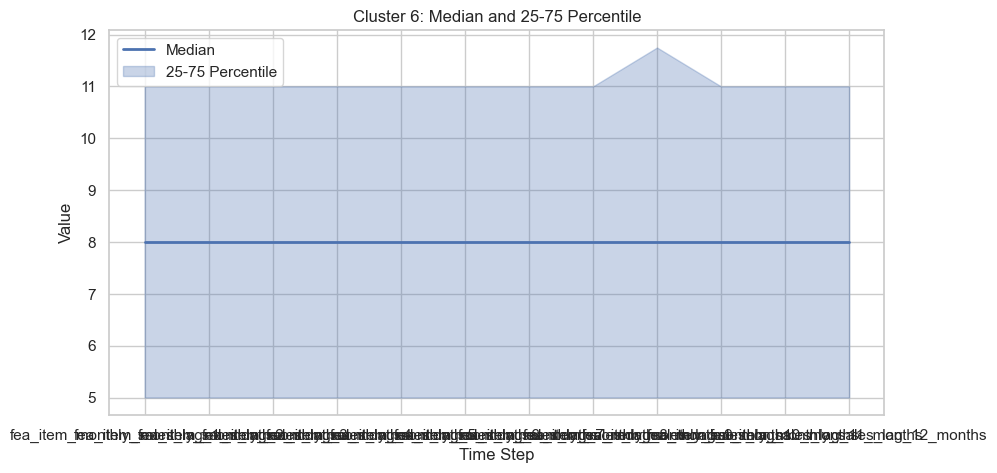

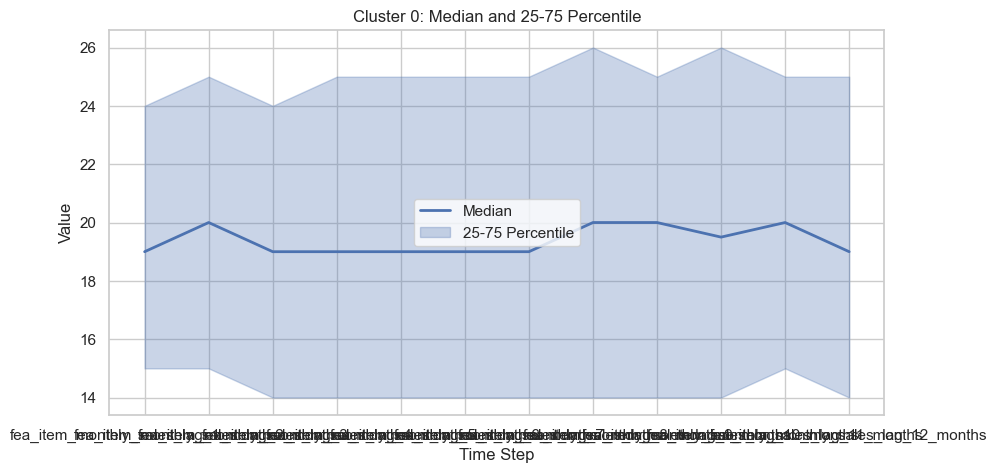

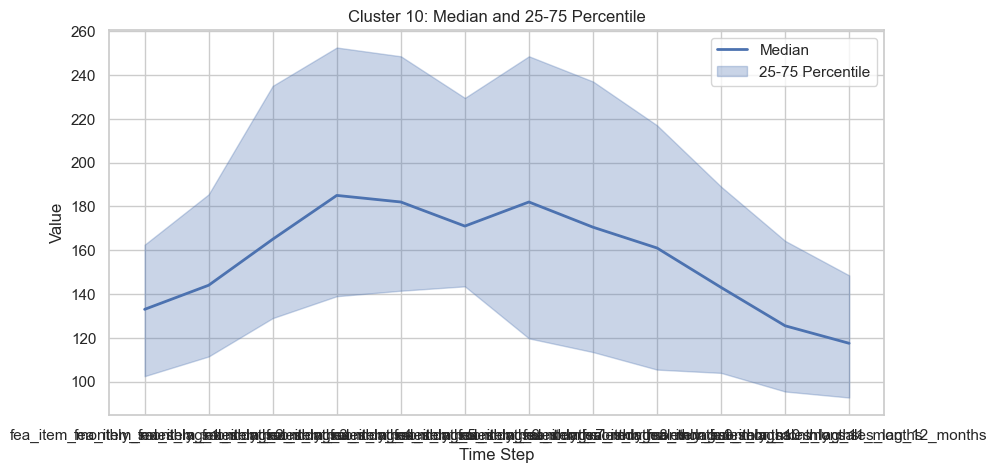

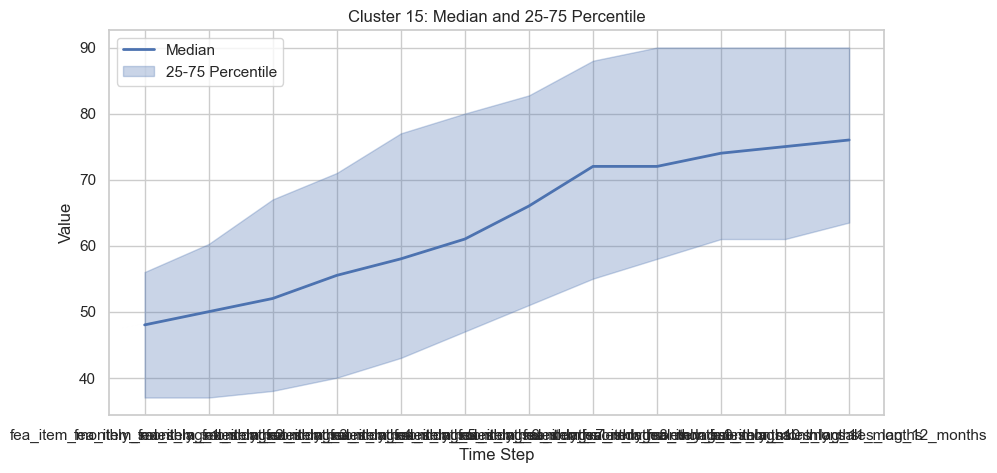

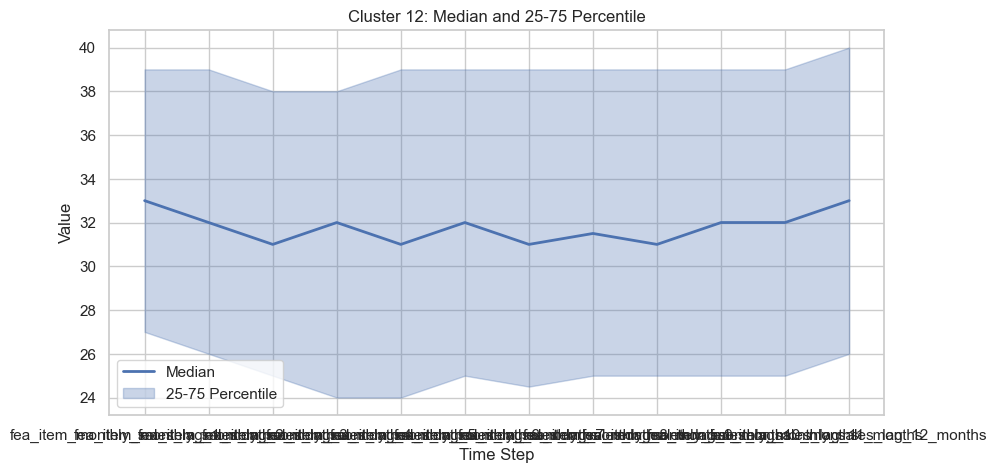

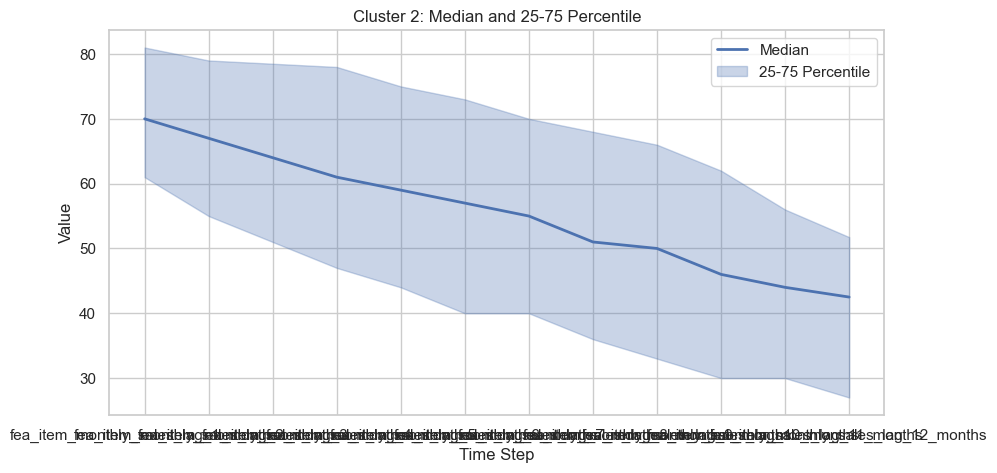

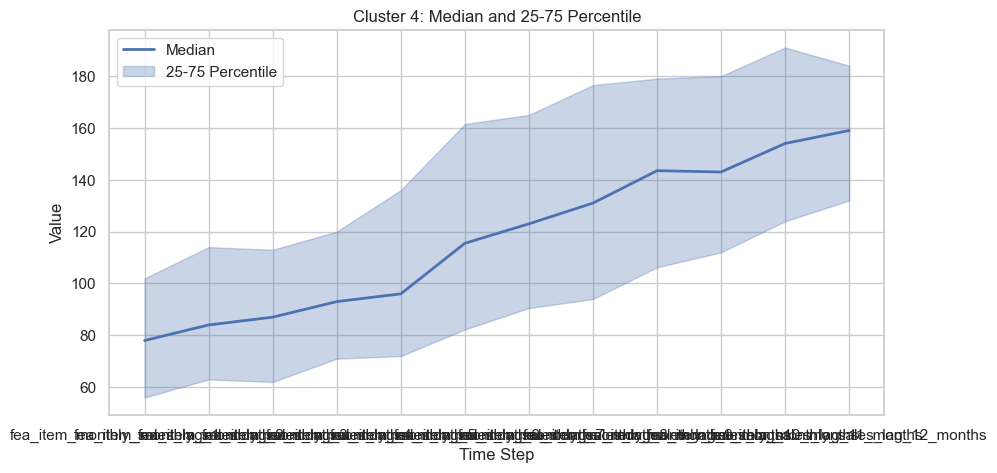

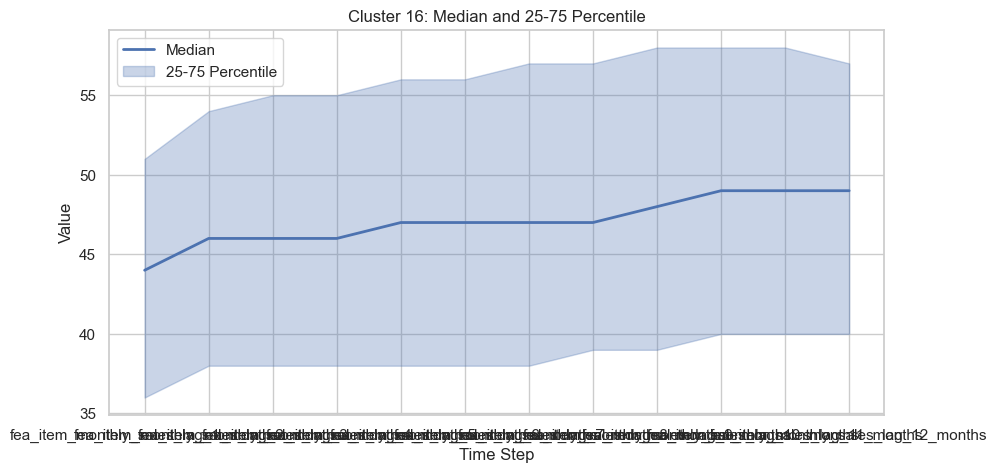

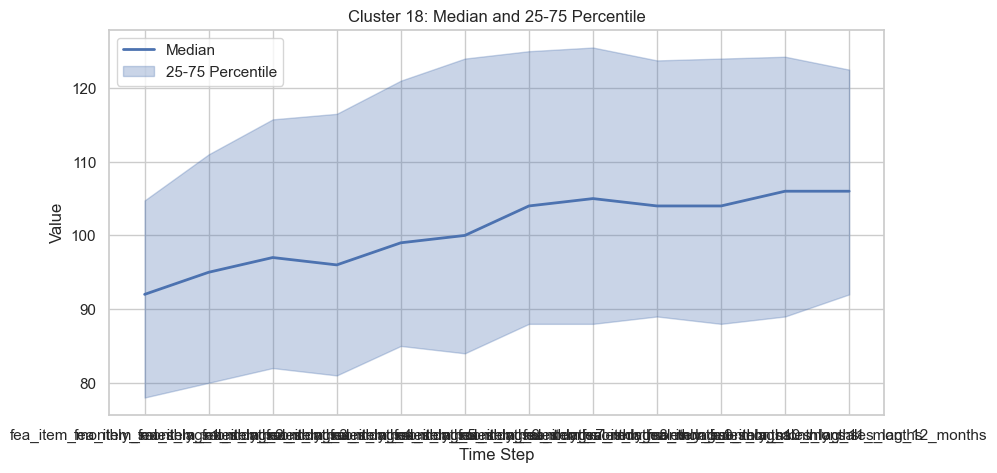

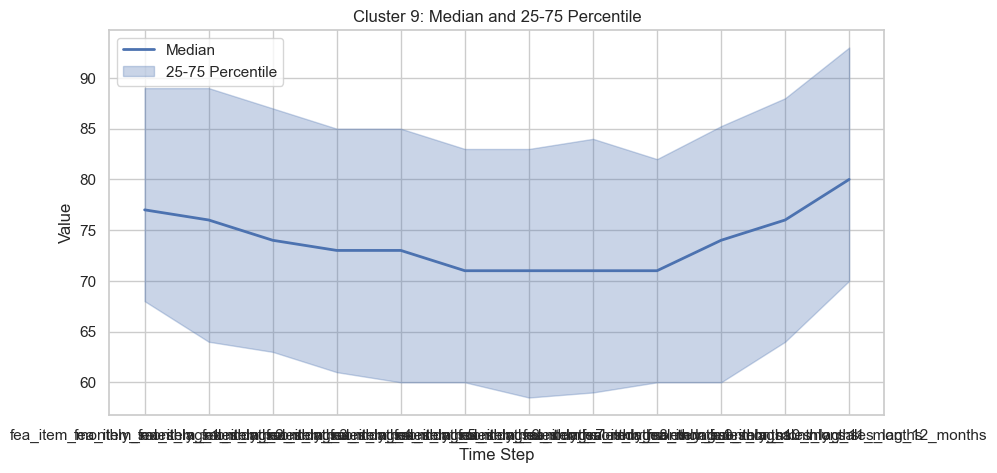

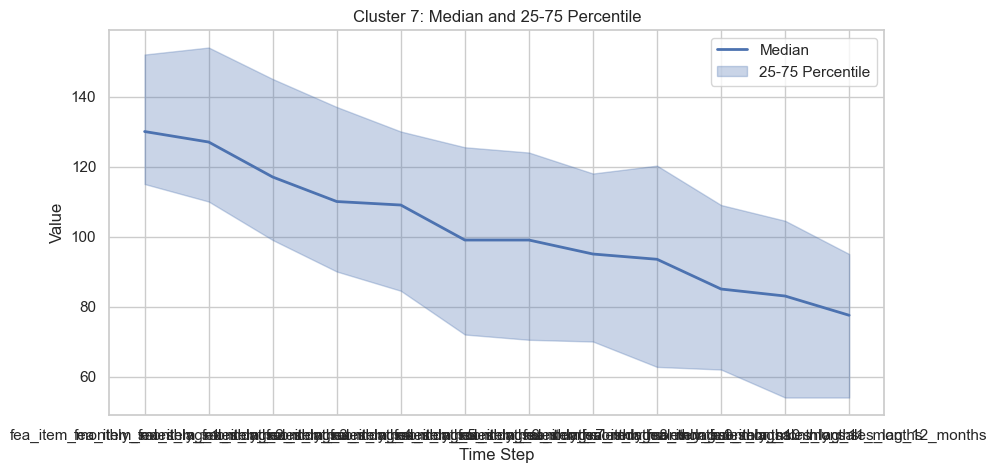

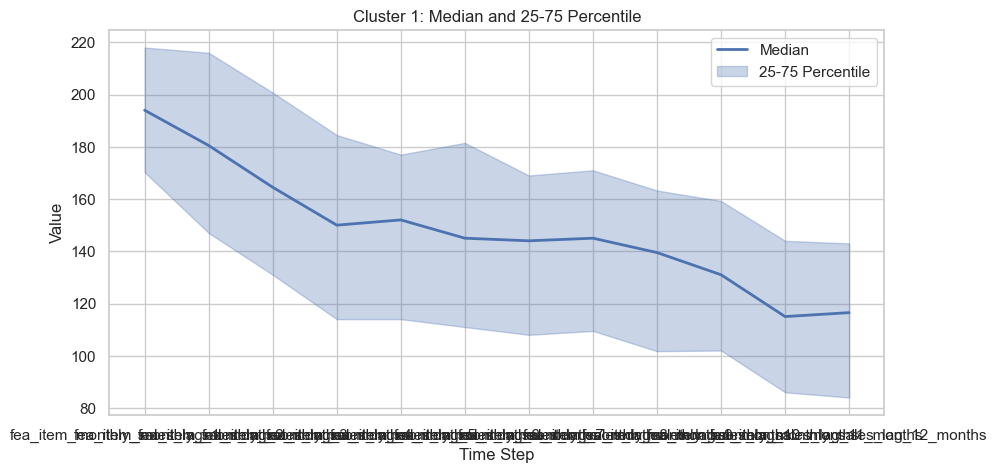

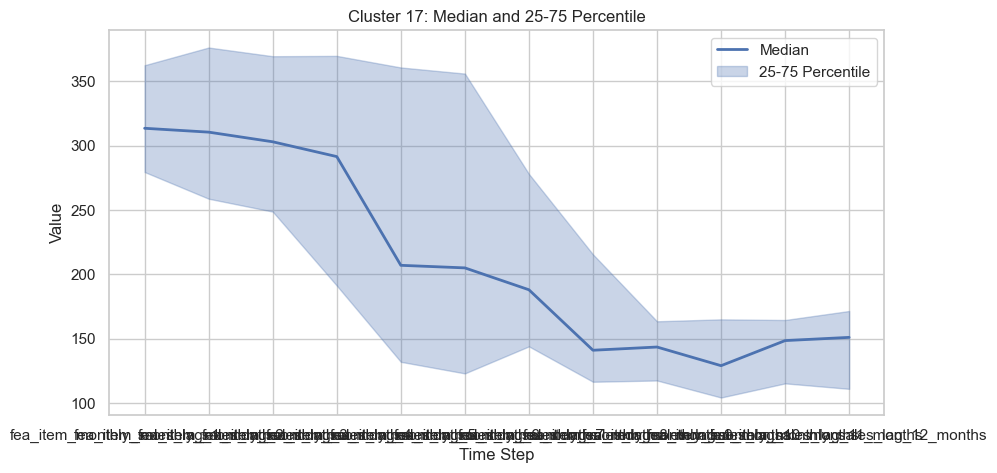

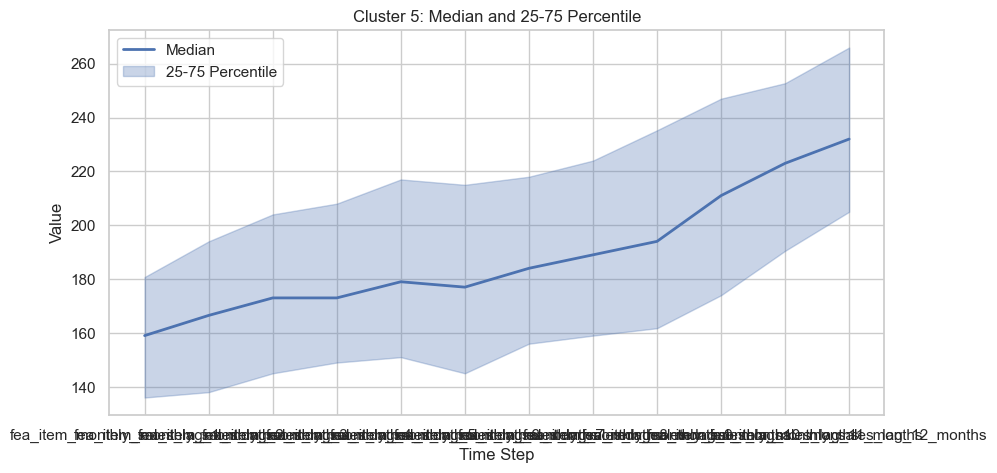

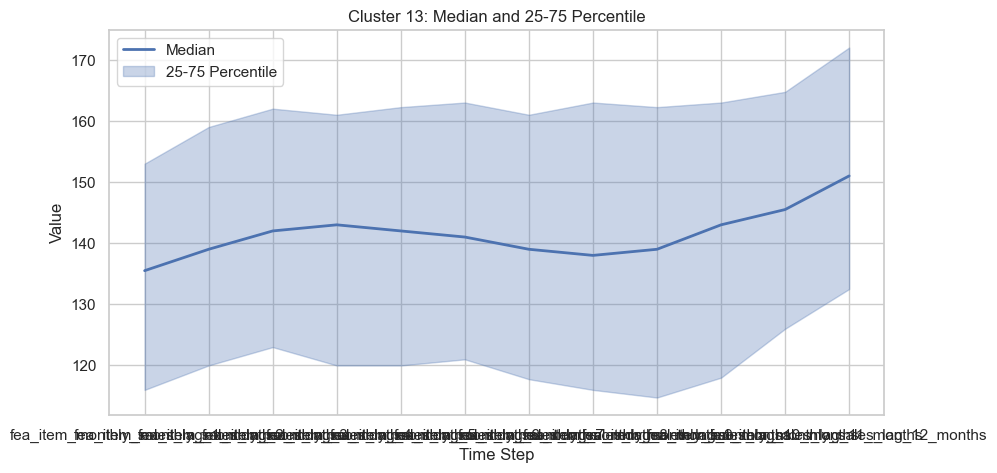

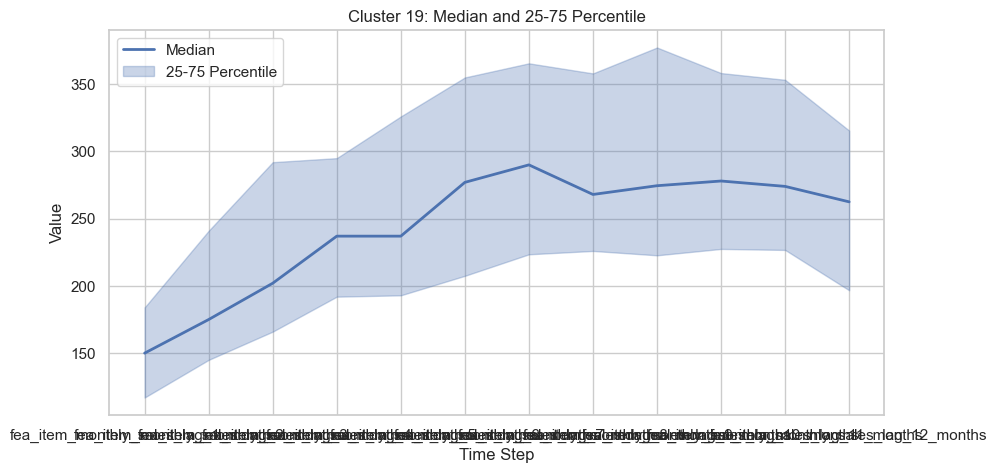

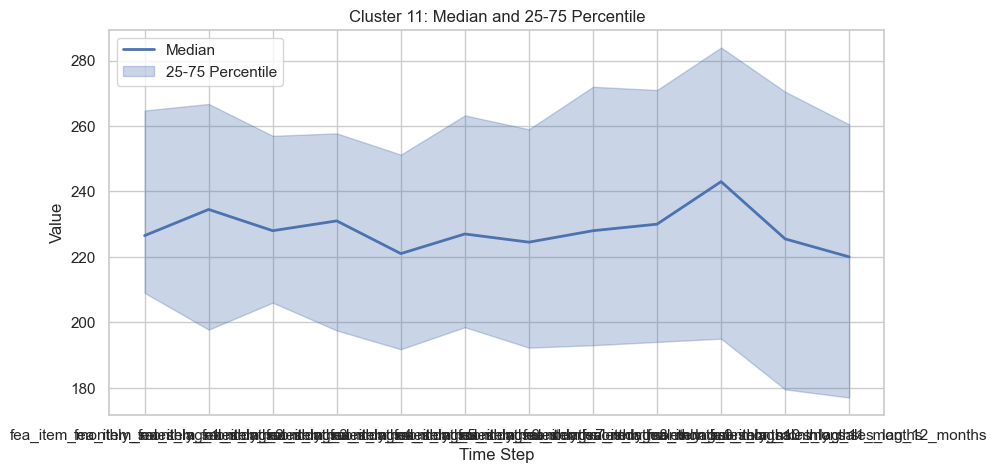

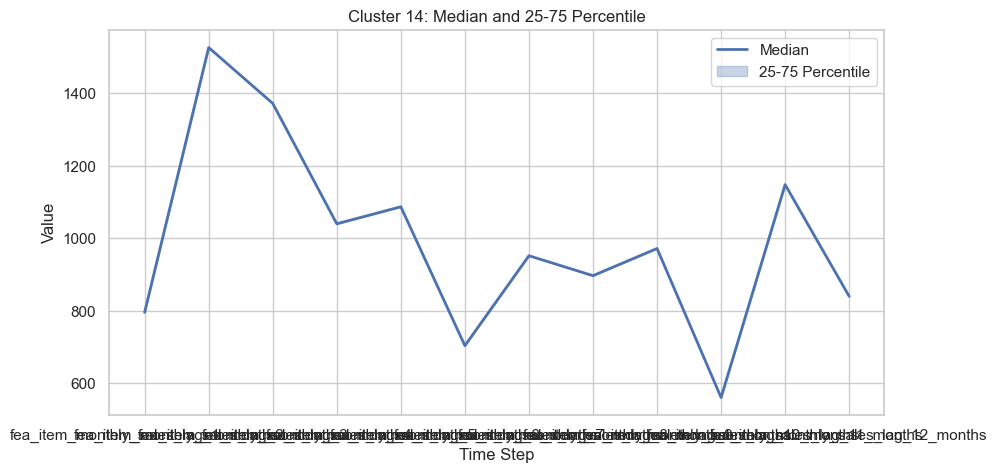

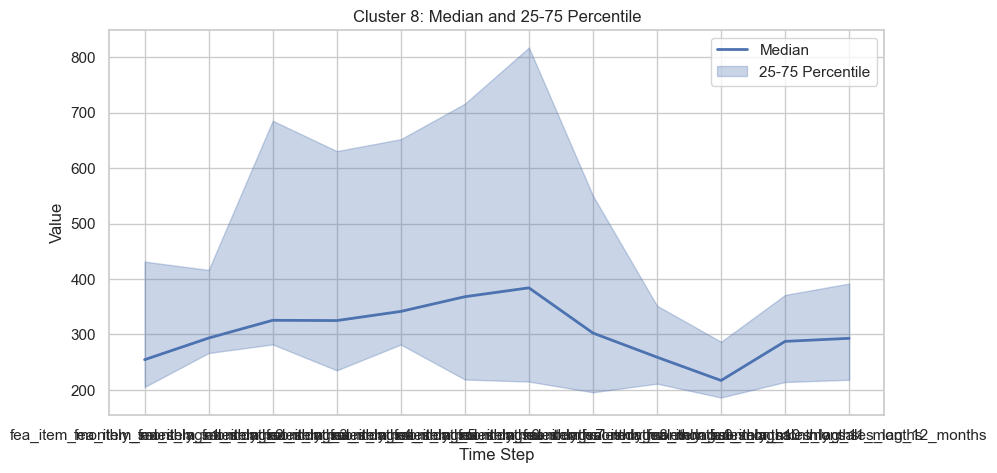

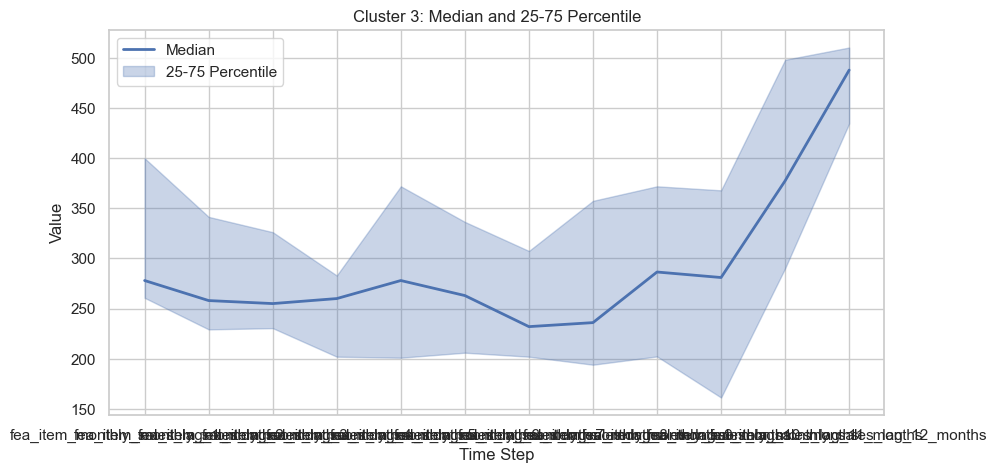

In [58]:
import matplotlib.pyplot as plt

# Set the cluster you want to plot
cluster_id = 6

def plot_cluster_ts(cluster_id):
    # Select only the time series columns (exclude 'clusters' if present)
    cluster_ts = ts_data[ts_data["clusters"] == cluster_id].drop(columns=["clusters"], errors='ignore')

    # Calculate statistics
    median = cluster_ts.median()
    q25 = cluster_ts.quantile(0.25)
    q75 = cluster_ts.quantile(0.75)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(median.index, median.values, label="Median", color="C0", linewidth=2)
    plt.fill_between(median.index, q25.values, q75.values, color="C0", alpha=0.3, label="25-75 Percentile")
    plt.title(f"Cluster {cluster_id}: Median and 25-75 Percentile")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

for cluster in df_results_display['clusters'].unique():
    plot_cluster_ts(cluster)


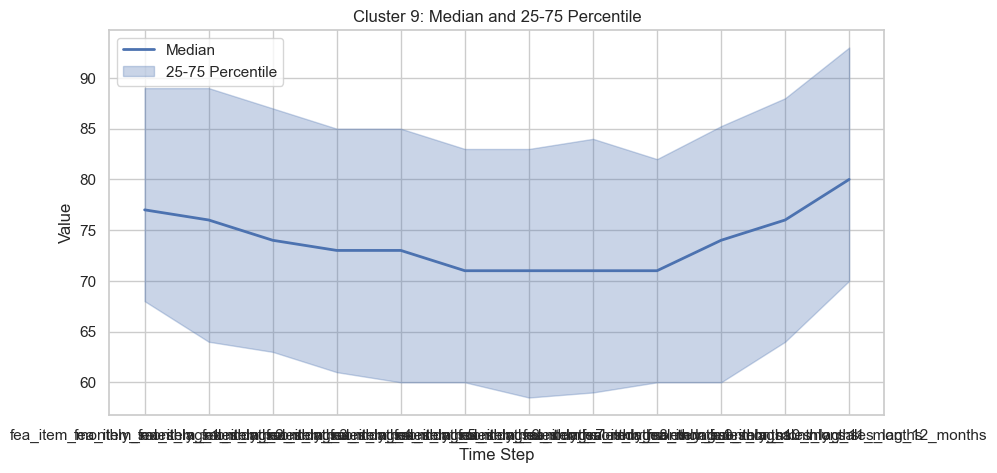

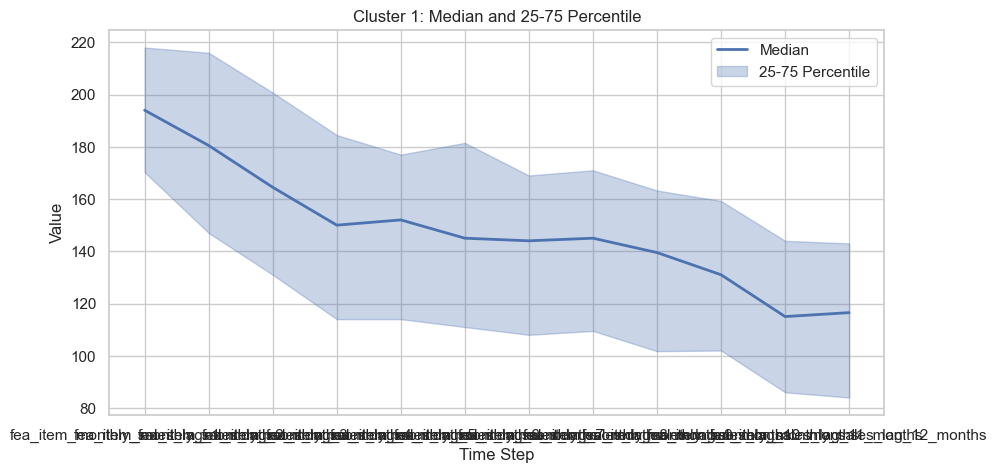

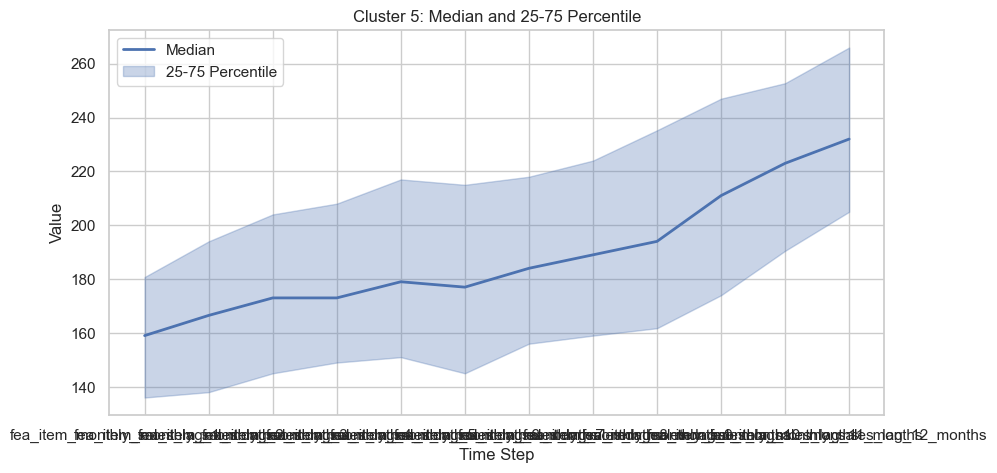

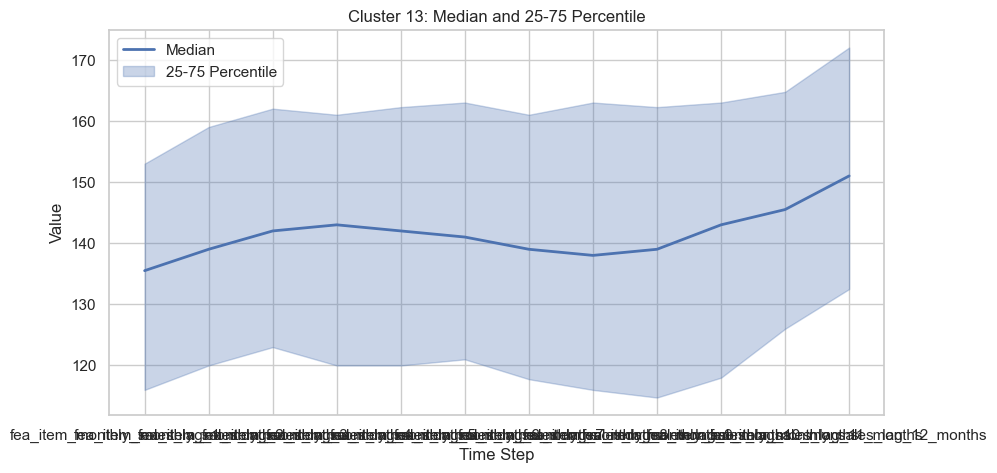

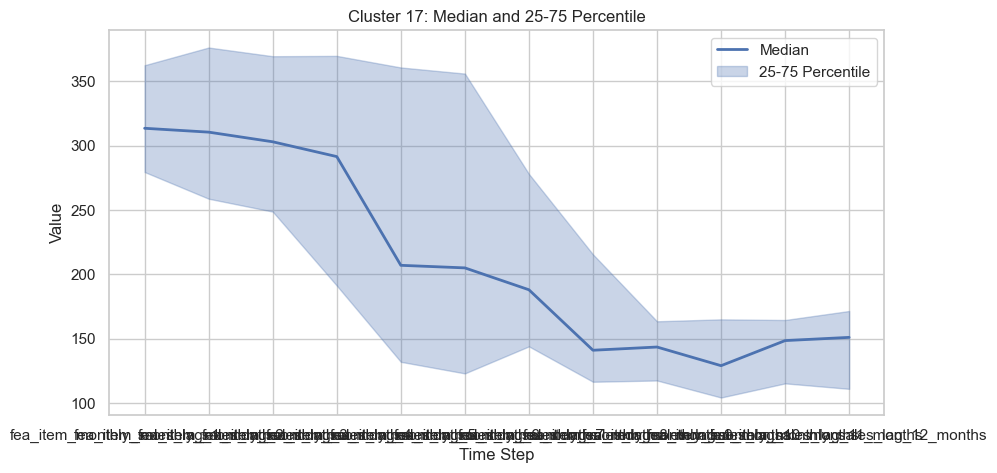

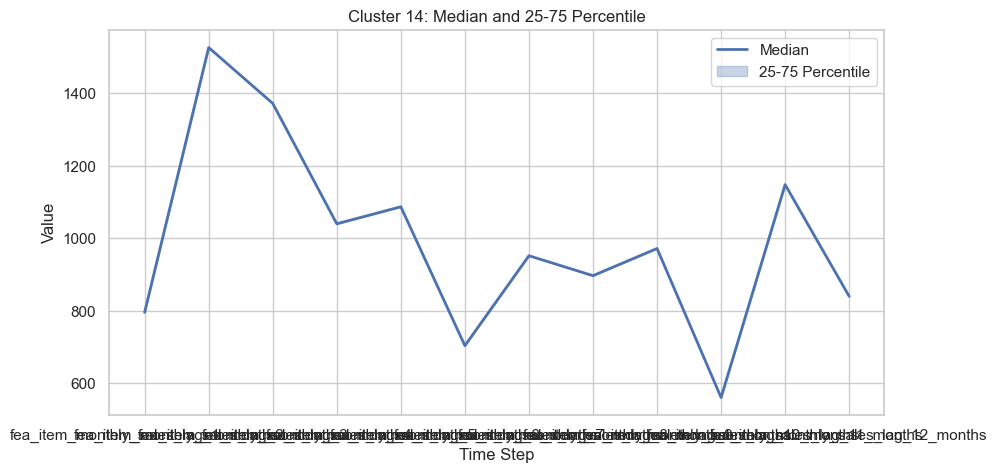

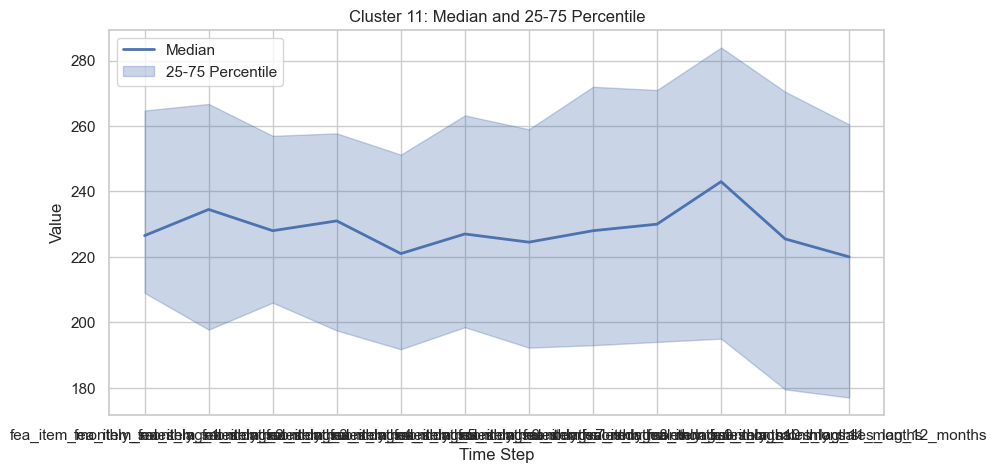

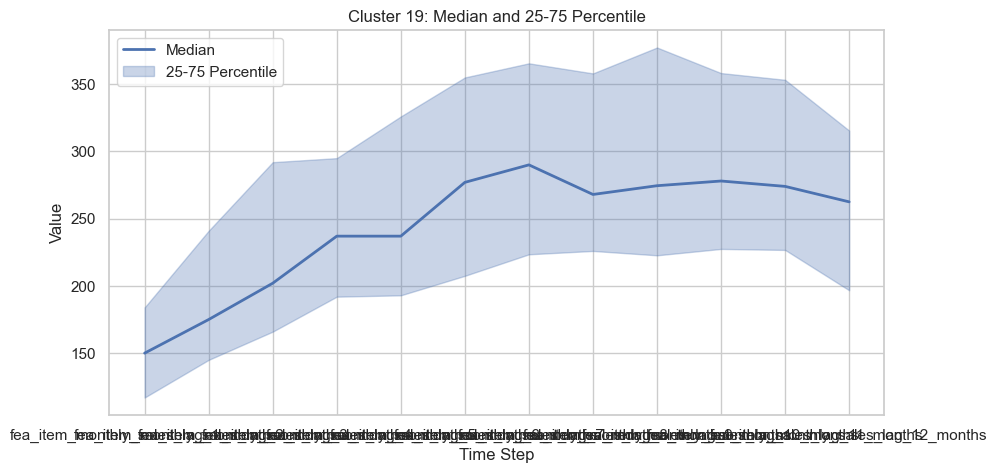

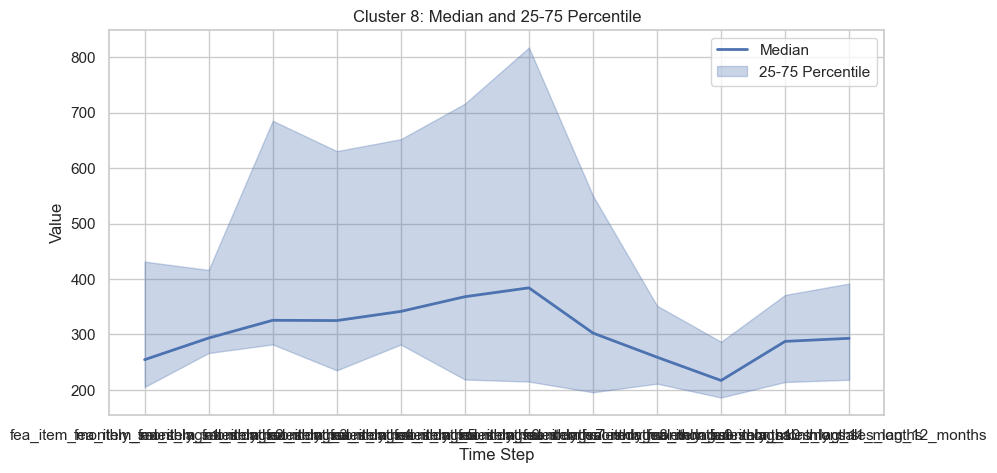

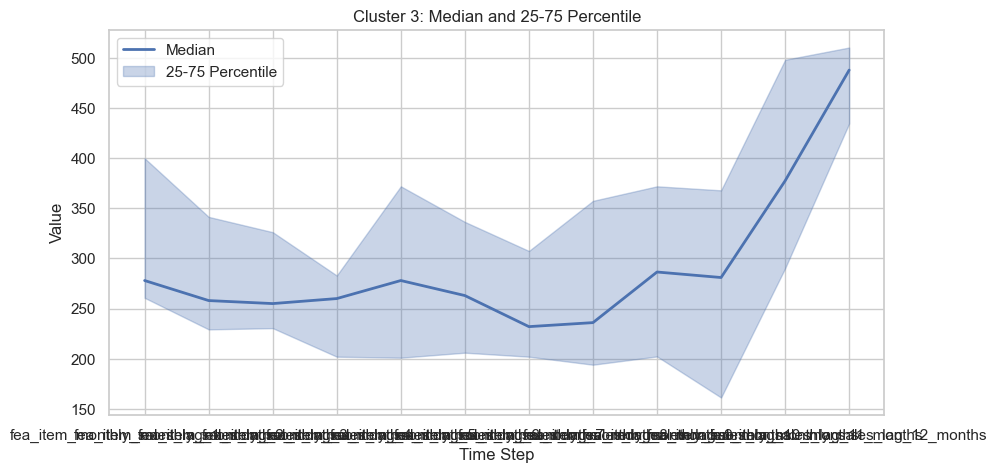

In [47]:
for cluster in [9, 1, 5, 13, 17, 14, 11, 19, 8 , 3]:
    plot_cluster_ts(cluster)